# **NAME**: Vedant Sinha

# Lab 4 Local Descriptor and Correspondance

In this lab, we will find corresponding points and regions between images using Harris corner detector. **Complete the implementation below and submit this notebook with your own result by Oct 7 23:59**.

## 1. Harris Corner Detector

The Harris corner detection algorithm is one of the simplest corner indicators available. The general idea is to locate interest points where the surrounding neighborhood shows edges in more than one direction, these are then image corners.

Following the lecture on 9/23, let's first implement the matrix $M$,
$$
M = \sum_{x,y} w(x,y) \begin{bmatrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2 \end{bmatrix}
$$
We use Gaussian filter for the window function $w(x, y)$.

Then we calculate the corner resopnse function,
$$
R = \det(M) - \alpha \text{trace}(M)^2
$$

Complete the functions below, which returns $I_x$, $I_y$, $I_{xy}$ and the corner response function.

In [4]:
from scipy.ndimage import gaussian_filter
import numpy as np


def compute_harris_response(im, sigma=3, alpha=0.05, return_derivatives=True):
    """Compute the Harris corner detector response function for each pixel in a grayscale image.

    Parameters
    ----------
    im : np.ndarray
        Grayscale image as 2D array.
    sigma : float
        Standard deviation for Gaussian window used in second-moment matrix.
    alpha : float
        Sensitivity factor in Harris response (typically 0.04~0.06).
    return_derivatives : bool
        Whether to return derivative images along with response.

    Returns
    -------
    If return_derivatives:
        ix, iy, ixy, response
    else:
        response
    """
    # Ensure floating point
    im = im.astype(np.float32)

    # Image derivatives using simple Sobel-like kernels
    # Note: Using gaussian_filter to compute smoothed derivatives improves stability
    ix = gaussian_filter(im, sigma=1, order=[0, 1])  # d/dx
    iy = gaussian_filter(im, sigma=1, order=[1, 0])  # d/dy
    ixy = ix * iy

    # Components of the second-moment matrix (structure tensor)
    Ixx = ix * ix
    Iyy = iy * iy
    Ixy = ixy

    # Apply Gaussian window to aggregate in local neighborhood
    Wxx = gaussian_filter(Ixx, sigma)
    Wxy = gaussian_filter(Ixy, sigma)
    Wyy = gaussian_filter(Iyy, sigma)

    # Harris response R = det(M) - alpha * trace(M)^2
    Wdet = (Wxx * Wyy) - (Wxy * Wxy)
    Wtr = Wxx + Wyy
    response = Wdet - (alpha * (Wtr ** 2))

    if return_derivatives:
        return ix, iy, ixy, response
    return response

This gives an image with each pixel containing the value of the Harris response function. Now it is just a matter of picking out the information needed from this image.

Take all points with values above a threshold and select every point with the largest value among its neighbors (non-maximum surpression).

To do this, take all candidate pixels, sort them in descending order of corneresponse values, and filter out points that are smaller than adjecent points.

In [5]:
def get_harris_points(harrisim, window=10, threshold=0.1):
    """ Return corners from a Harris response image.
    window is the window size separating corners and
    image boundary during non-maximum suppression.
    """
    # Find top corner candidates above a threshold
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1

    # Get coordinates of candidates
    coords = np.array(harrisim_t.nonzero()).T

    # ...and their values
    candidate_values = [harrisim[c[0],c[1]] for c in coords]

    # Sort candidates
    index = np.argsort(candidate_values)[::-1] # Sort in descending order

    # Select the best points using non-maximum suppression
    filtered_coords = []
    # Create a copy of the harris response image for suppression
    harrisim_suppressed = harrisim.copy()

    for i in index:
        r, c = coords[i]
        # Ensure point is within the image boundary considering min_dist
        if r > window and r < harrisim.shape[0] - window and c > window and c < harrisim.shape[1] - window:
            # Check if the current point has the maximum response in its neighborhood
            if harrisim_suppressed[r, c] == harrisim[r, c]:
                filtered_coords.append((r, c))
                # Suppress the neighborhood using min_dist as the size of the suppression window
                harrisim_suppressed[max(0, r - window):min(harrisim.shape[0], r + window + 1),
                                    max(0, c - window):min(harrisim.shape[1], c + window + 1)] = 0

    return filtered_coords

Now we have all we need to detect corner points in images. To show the corner
points in the image we can add a plotting function using Matplotlib as follows.

In [6]:
import matplotlib.pyplot as plt

def normalize(im):
    im = (im - im.min()) / (im.max() - im.min())
    im = (im * 255).astype(np.uint8)
    return im

def plot_harris_points(image, filtered_coords):
    """ Plots corners found in image.
    """
    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords], 'o')
    plt.axis('off')
    plt.show()

Detect the corners of `checkboard.png` and `cameraman.png`. Show their $I_x$, $I_y$, and $I_{xy}$

### Checkboard

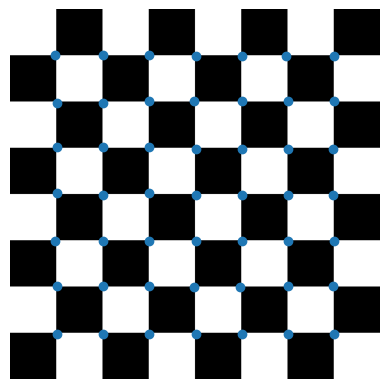

In [16]:
from PIL import Image

im = np.array(Image.open('checkboard.png').convert('L'))
ix, iy, ixy, harrisim = compute_harris_response(im, sigma=2, alpha=0.05)
filtered_coords = get_harris_points(harrisim, window=8, threshold=0.1)
plot_harris_points(im, filtered_coords)

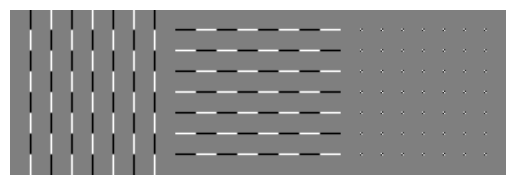

In [8]:
derivatives = np.concatenate([normalize(ix), normalize(iy), normalize(ixy)], axis=1)
plt.imshow(derivatives, cmap='gray')
plt.axis('off')
plt.show()

### Cameraman

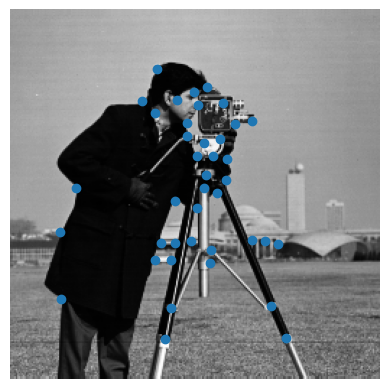

In [17]:
im = np.array(Image.open('cameraman.png').convert('L'))
ix, iy, ixy, harrisim = compute_harris_response(im, sigma=2, alpha=0.05)
filtered_coords_cam = get_harris_points(harrisim, window=8, threshold=0.1)
plot_harris_points(im, filtered_coords_cam)

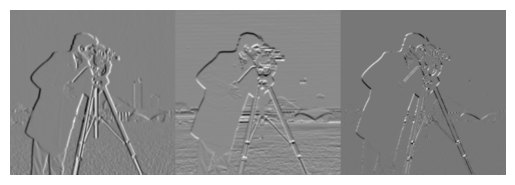

In [10]:
derivatives = np.concatenate([normalize(ix), normalize(iy), normalize(ixy)], axis=1)
plt.imshow(derivatives)
plt.axis('off')
plt.show()

### Analysis

Incrementally apply stronger blur (or ROF de-noising) to one image and extract Harris corners. What happens?

Show the results and provide your analysis.

_Answer_

## 2. Finding Corresponding Points between Images

Next, let's find corresponding points between images. We will first detect points (corners) in the two images and then match similar points between the images by estimating their similarity.

After detecting points using Harris corner detection in the previous section, we crop patches from the images at the corners.

In [11]:
def get_descriptors(image, filtered_coords, wid=5):
    """ For each point return pixel values around the point
        using a neighbourhood of width 2*wid+1. (Assume points are
        extracted with min_distance > wid). """

    desc = []
    for coords in filtered_coords:
        patch = image[coords[0]-wid:coords[0]+wid+1,
            coords[1]-wid:coords[1]+wid+1].flatten()
        desc.append(patch)

    return desc

Then we estimate the similarity between patches of the two images using _Normalized Cross Correlation_ (NCC).

_Normalized cross correlation_ is a variant of cross correlation defined as
$$
\text{NCC}(I_1, I_2) = \frac{1}{n-1} \sum_{\mathbf{x}} \frac{(I_1(\mathbf{x}) - \mu_1)}{\sigma_1} \cdot \frac{(I_2(\mathbf{x}) - \mu_2)}{\sigma_2},
$$

where $n$ is the number of pixels in a patch, $\mu_1$ and $\mu_2$ are the mean intensities, and
$\sigma_1$ and $\sigma_2$ are the standard deviations in each patch respectively. By subtracting the
mean and scaling with the standard deviation, the method becomes robust to changes in image brightness.

In [12]:
def match(desc1, desc2, threshold=0.5):
    """For each descriptor in desc1, select its match in desc2 using NCC.

    Returns
    -------
    np.ndarray of shape (len(desc1),) with indices into desc2 or -1 if no match.
    """
    if len(desc1) == 0 or len(desc2) == 0:
        return -np.ones((len(desc1),), dtype=int)

    n = len(desc1[0])

    # pair-wise NCC scores initialized to -1
    d = -np.ones((len(desc1), len(desc2)), dtype=np.float32)
    for i in range(len(desc1)):
        patch1 = desc1[i].astype(np.float32)
        mu1 = patch1.mean()
        std1 = patch1.std()
        if std1 < 1e-6:
            continue
        d1 = (patch1 - mu1) / std1
        for j in range(len(desc2)):
            patch2 = desc2[j].astype(np.float32)
            mu2 = patch2.mean()
            std2 = patch2.std()
            if std2 < 1e-6:
                continue
            d2 = (patch2 - mu2) / std2
            ncc_value = float(np.dot(d1, d2) / (n - 1))
            if ncc_value > threshold:
                d[i, j] = ncc_value

    # best match per desc1; if all are -1, keep -1
    matchscores = -np.ones((len(desc1),), dtype=int)
    for i in range(len(desc1)):
        j_best = int(np.argmax(d[i]))
        if d[i, j_best] > 0:
            matchscores[i] = j_best
    return matchscores

To further stabilize the matches, we can match from the second image to the
first and filter out the matches that are not the best both ways. The following function does just that.

In [13]:
def match_twosided(desc1, desc2, threshold=0.5):
    """ Two-sided symmetric version of match(). """

    matches_12 = match(desc1, desc2, threshold)
    matches_21 = match(desc2, desc1, threshold)
    ndx_12 = np.where(matches_12 >= 0)[0]

    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1

    return matches_12

The matches can be visualized by showing the images side-by-side and connecting matched points with lines using the following code.

In [14]:
def appendimages(im1, im2):
    """ Return a new image that appends the two images side-by-side."""

    # select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]

    if rows1 < rows2:
        im1 = np.concatenate((im1, np.zeros((rows2-rows1, im1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = np.concatenate((im2, np.zeros((rows1-rows2, im2.shape[1]))), axis=0)
    # if none of these cases they are equal, no filling needed.

    return np.concatenate((im1,im2), axis=1)

def plot_matches(im1, im2, locs1, locs2, matchscores, show_below=True):
    """ Show a figure with lines joining the accepted matches
    input: im1,im2 (images as arrays), locs1,locs2 (feature locations),
    matchscores (as output from ’match()’),
    show_below (if images should be shown below matches). """

    im3 = appendimages(im1, im2)
    if show_below:
        im3 = np.vstack((im3, im3))

    plt.imshow(im3)

    cols1 = im1.shape[1]
    for i, m in enumerate(matchscores):
        if m > 0:
            plt.plot([locs1[i][1], locs2[m][1]+cols1], [locs1[i][0], locs2[m][0]], 'c')
    plt.axis('off')

Plot the matching results between `ucm1.jpg` and `ucm2.jpg`.

starting matching


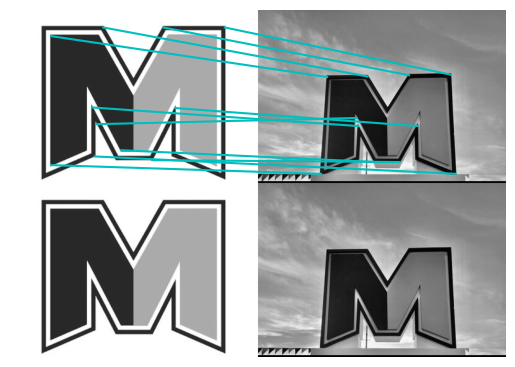

In [18]:
im1 = np.array(Image.open('ucm1.jpg').convert('L'))
im2 = np.array(Image.open('ucm2.jpg').convert('L'))

# Detect Harris corners on both images
_, _, _, harrisim1 = compute_harris_response(im1, sigma=2, alpha=0.05)
filtered_coords1 = get_harris_points(harrisim1, window=8, threshold=0.1)

_, _, _, harrisim2 = compute_harris_response(im2, sigma=2, alpha=0.05)
filtered_coords2 = get_harris_points(harrisim2, window=8, threshold=0.1)

# Extract patch descriptors around each corner (ensure wid < window)
d1 = get_descriptors(im1, filtered_coords1, wid=5)
d2 = get_descriptors(im2, filtered_coords2, wid=5)

print('starting matching')
matches = match_twosided(d1, d2)

plt.figure()
plt.gray()
plot_matches(im1, im2, filtered_coords1, filtered_coords2, matches)
plt.show()

## Analysis

Which parts match, and which parts fail? Describe what you observe.

- Strong, repeatable corners on high-contrast structures tend to match reliably. These regions produce stable Harris responses and the local patches have distinctive gradients, so NCC is high.
- Repeated textures or near-symmetric patterns produce ambiguous descriptors. NCC may select a wrong patch, which leads to mismatches.
- Low-texture or flat regions rarely generate corners but when they do, matches are weak.
- Illumination differences reduce NCC if contrast changes are not normalized enough. We normalize per-patch, which helps, but strong lighting variations still hurt.

Overall, matches concentrate on crisp, unique corners and failures occur in repetitive textures, low-texture areas, or where appearance changes in scale/pose/lighting exceed what Harris+NCC can handle.